In [1]:
import json
import pandas as pd
import wandb
from tempfile import TemporaryDirectory
import matplotlib.pyplot as plt

%matplotlib inline
import seaborn as sns

sns.set_theme()
# %config InlineBackend.figure_format = "png"

In [2]:
def summary_data(run_id: str):
    api = wandb.Api()
    run = api.run(run_id)
    dfs = []

    with TemporaryDirectory() as tmpdir:
        for table in run.logged_artifacts():
            table_dir = table.download(tmpdir)
            table_name = "perf_metrics"
            table_path = f"{table_dir}/{table_name}.table.json"
            with open(table_path) as file:
                json_dict = json.load(file)

            df = pd.DataFrame(json_dict["data"], columns=json_dict["columns"])
            dfs.append(df.mean().to_frame().T)

    return pd.concat(dfs)

## IPU Gather

In [3]:
# %%capture
# gather_df = summary_data('hatemh/mpbench/runs/35wuezs3')
# gather_df.to_pickle('ipu_gather.pickle')

In [4]:
gather_df = pd.read_pickle("bow/gather.pickle")

In [5]:
gather_df

,num_inputs,num_features,num_outputs,cycles,time (μs),effective bandwidth (GiB/s)
0,16.0,16.0,32.0,1388.620312,0.750606,2.541085
0,16.0,16.0,64.0,1484.377187,0.802366,4.754318
0,16.0,16.0,128.0,1597.835938,0.863695,8.833450
0,16.0,16.0,256.0,1651.322813,0.892607,17.094650
0,16.0,16.0,512.0,1637.739687,0.885265,34.472855
...,...,...,...,...,...,...
0,4096.0,512.0,2048.0,21234.078438,11.477880,340.328521
0,4096.0,512.0,4096.0,30176.369687,16.311551,478.955062
0,4096.0,512.0,8192.0,42314.787187,22.872858,683.124079
0,4096.0,512.0,16384.0,60853.240937,32.893644,950.031570


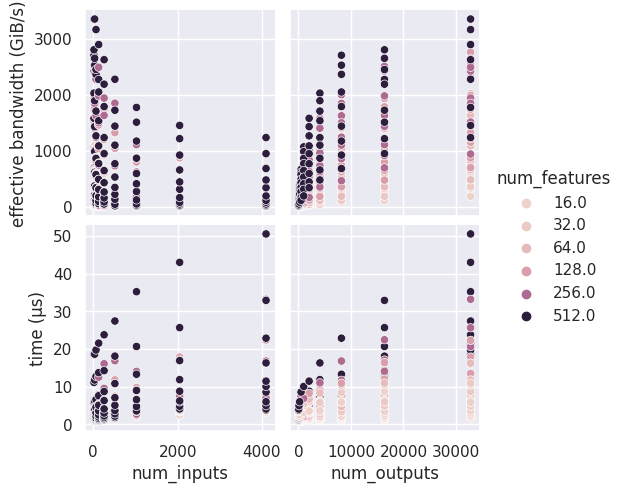

In [6]:
sns.pairplot(
    data=gather_df,
    x_vars=["num_inputs", "num_outputs"],
    y_vars=["effective bandwidth (GiB/s)", "time (μs)"],
    hue="num_features",
)

## IPU Scatter Sum

In [7]:
# %%capture
# scatter_df = summary_data('hatemh/mpbench/3jtznemn')
# scatter_df.to_pickle('ipu_scatter_sum.pickle')

In [8]:
scatter_df = pd.read_pickle("bow/scatter_add.pickle")

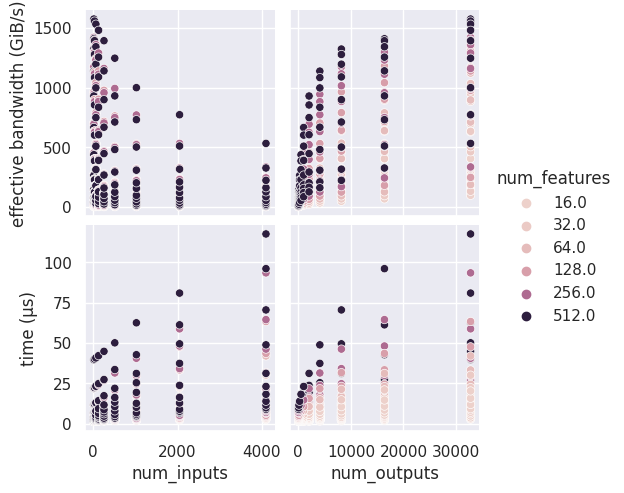

In [9]:
sns.pairplot(
    data=scatter_df,
    x_vars=["num_inputs", "num_outputs"],
    y_vars=["effective bandwidth (GiB/s)", "time (μs)"],
    hue="num_features",
)

## IPU SchNet Interaction Block

In [10]:
# %%capture
# schnet_block_df = summary_data('hatemh/mpbench/1xm2gtim')
# schnet_block_df.to_pickle('ipu_schnet_block.pickle')

In [11]:
schnet_block_df = pd.read_pickle("bow/schnet_block.pickle")

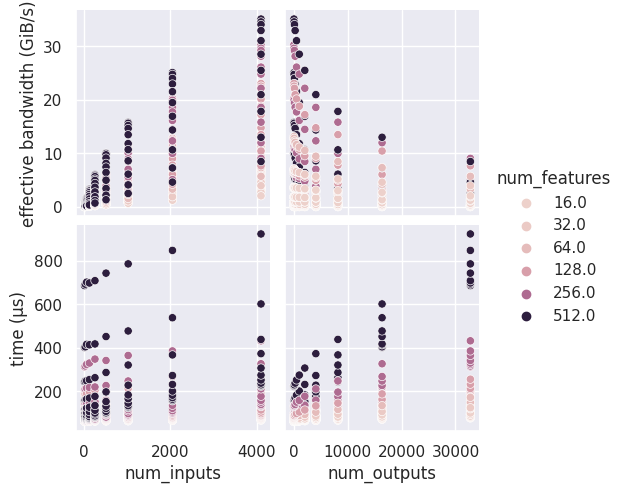

In [12]:
sns.pairplot(
    data=schnet_block_df,
    x_vars=["num_inputs", "num_outputs"],
    y_vars=["effective bandwidth (GiB/s)", "time (μs)"],
    hue="num_features",
)

## Bow IPU compared to A100

In [13]:
def read_operation(operation: str):
    a = pd.read_csv(f"a100/{operation}.csv")
    b = pd.read_csv(f"bow/{operation}.csv").reset_index()

    b_time = b["time (μs)"]
    b_time = b_time.rename("Bow IPU time (μs)")
    a_time = a["time"].rename("A100 time (μs)")

    speedup = a_time / b_time
    speedup = speedup.rename("Speedup (A100 / Bow IPU)")

    return pd.concat(
        [a[["num_inputs", "num_features", "num_outputs"]], a_time, b_time, speedup],
        axis=1,
    )

In [14]:
data = []
op_to_name = {
    "gather": "Gather",
    "scatter_add": "Scatter Add",
    "schnet_block": "SchNet Block",
}

for op in ["gather", "scatter_add", "schnet_block"]:
    df = read_operation(op)
    df.insert(0, "Operation", op_to_name[op])
    data.append(df)

df = pd.concat(data, axis=0)

df.head()

,Operation,num_inputs,num_features,num_outputs,A100 time (μs),Bow IPU time (μs),Speedup (A100 / Bow IPU)
0,Gather,16,16,32,10.073047,0.750606,13.419893
1,Gather,16,16,64,9.281059,0.802366,11.567114
2,Gather,16,16,128,9.640346,0.863695,11.161747
3,Gather,16,16,256,9.605402,0.892607,10.761066
4,Gather,16,16,512,8.989300,0.885265,10.154364


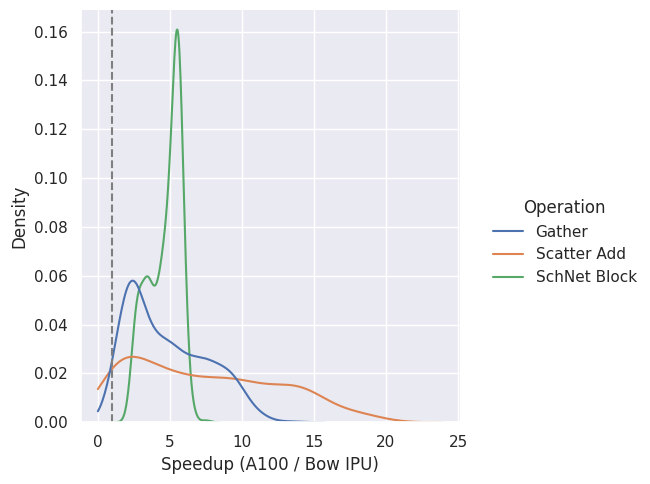

In [15]:
ax = sns.displot(data=df, x=df.columns[-1], hue="Operation", kind="kde", clip=[0, None])
ax.ax.axvline(x=1.0, ls="--", c="tab:grey")
plt.show()

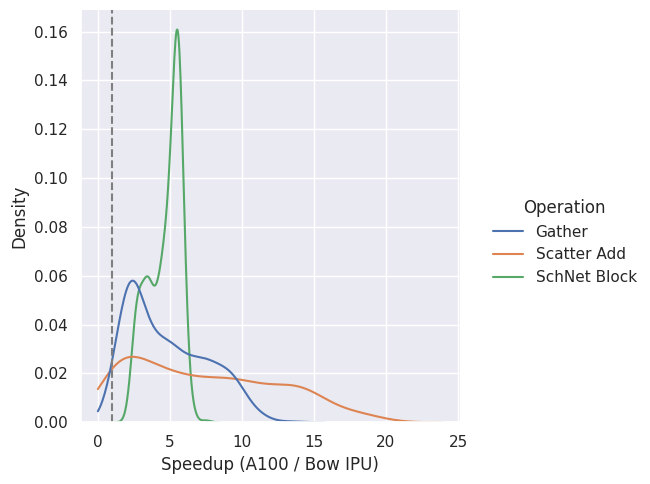

In [16]:
ax = sns.displot(data=df, x=df.columns[-1], hue="Operation", kind="kde", clip=[0, None])
ax.ax.axvline(x=1.0, ls="--", c="tab:grey")
plt.show()

In [17]:
df["Speedup (A100 / Bow IPU)"].describe()

count    1782.000000
mean        5.636186
std         3.587880
min         0.326693
25%         3.053876
50%         5.074911
75%         6.890090
max        19.734303
Name: Speedup (A100 / Bow IPU), dtype: float64

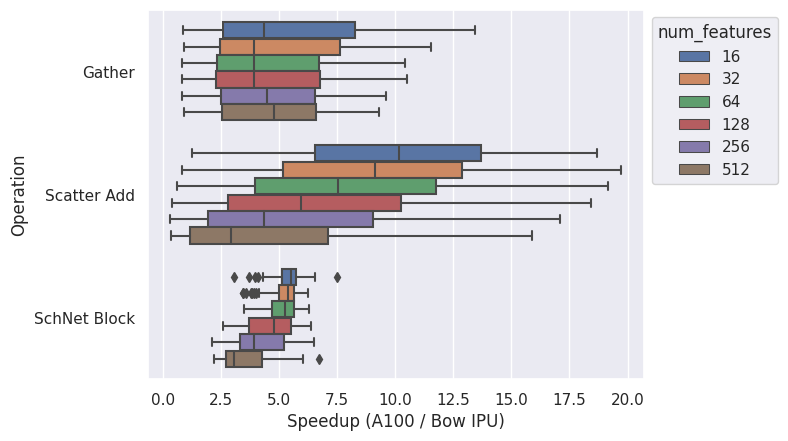

In [18]:
ax = sns.boxplot(data=df, x=df.columns[-1], y="Operation", hue="num_features")
sns.move_legend(ax, loc="upper left", bbox_to_anchor=(1, 1))

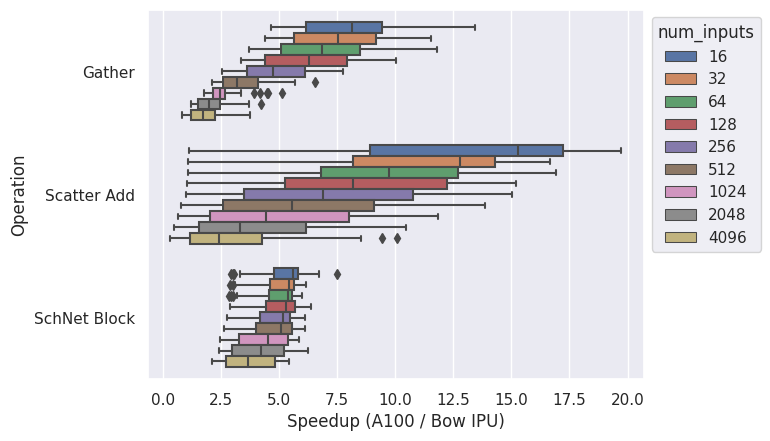

In [19]:
ax = sns.boxplot(data=df, x=df.columns[-1], y="Operation", hue="num_inputs")
sns.move_legend(ax, loc="upper left", bbox_to_anchor=(1, 1))

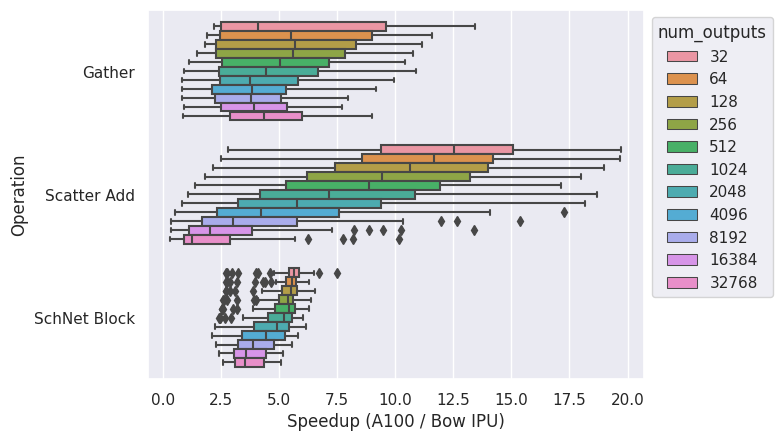

In [20]:
ax = sns.boxplot(data=df, x=df.columns[-1], y="Operation", hue="num_outputs")
sns.move_legend(ax, loc="upper left", bbox_to_anchor=(1, 1))

In [21]:
speedup = df["Speedup (A100 / Bow IPU)"]
slow_mask = speedup < 1
speedup[slow_mask].describe()

count    43.000000
mean      0.700931
std       0.186592
min       0.326693
25%       0.549255
50%       0.785238
75%       0.838458
max       0.994453
Name: Speedup (A100 / Bow IPU), dtype: float64

In [22]:
100 * speedup[slow_mask].count() / speedup.count()

2.4130190796857462

In [23]:
df[slow_mask]

,Operation,num_inputs,num_features,num_outputs,A100 time (μs),Bow IPU time (μs),Speedup (A100 / Bow IPU)
538,Gather,4096,16,32768,8.988234,10.449066,0.860195
548,Gather,4096,32,16384,9.392580,10.530148,0.891970
558,Gather,4096,64,8192,8.807559,10.416645,0.845527
568,Gather,4096,128,4096,8.675624,10.578935,0.820085
578,Gather,4096,256,2048,9.525104,11.640365,0.818282
588,Gather,4096,512,1024,9.100402,10.079000,0.902907
328,Scatter Add,256,512,16384,27.257474,27.409522,0.994453
329,Scatter Add,256,512,32768,44.451966,44.864467,0.990806
384,Scatter Add,512,256,32768,26.642643,31.481961,0.846283
394,Scatter Add,512,512,16384,26.453376,33.590766,0.787519
